In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, recall_score, classification_report
import optuna
from pycaret.classification import *

In [20]:
# 셀 2: 데이터 로드 및 전처리
data = pd.read_csv('bank.csv')
print(data.info())
print("\nTarget variable distribution before handling missing values:")
print(data['deposit'].value_counts(normalize=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11162 non-null  int64 
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(7), object(10)
memory usage: 1.4+ MB
None

Target variable distribution before handling missing values:
deposit
no     0.52616
yes    0.

In [21]:
# 결측값 처리
data = data.dropna()
print("\nTarget variable distribution after handling missing values:")
print(data['deposit'].value_counts(normalize=True))


Target variable distribution after handling missing values:
deposit
no     0.52616
yes    0.47384
Name: proportion, dtype: float64


In [23]:
# 타겟 변수 인코딩
data['deposit'] = (data['deposit'] == 'yes').astype(int)

In [24]:
# 특성과 타겟 분리
X = data.drop('deposit', axis=1)
y = data['deposit']

In [25]:
# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
# 셀 3: 데이터 전처리 및 특성 선택
categorical_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
numeric_features = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
    ])


In [28]:
# 전처리 적용
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

In [29]:
# 특성 이름 생성
feature_names = (numeric_features +
                 preprocessor.named_transformers_['cat']
                 .get_feature_names_out(categorical_features).tolist())


In [30]:
# 특성 선택
sfs = SequentialFeatureSelector(LogisticRegression(random_state=42), n_features_to_select='auto', direction='forward', cv=5)
sfs.fit(X_train_preprocessed, y_train)

selected_features = np.array(feature_names)[sfs.get_support()].tolist()
print(f"선택된 특성: {selected_features}")

X_train_selected = sfs.transform(X_train_preprocessed)
X_test_selected = sfs.transform(X_test_preprocessed)

선택된 특성: ['balance', 'duration', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_self-employed', 'job_student', 'job_unknown', 'education_secondary', 'education_unknown', 'housing_yes', 'loan_yes', 'contact_unknown', 'month_dec', 'month_jun', 'month_mar', 'month_may', 'month_oct', 'month_sep', 'poutcome_success', 'poutcome_unknown']


In [31]:
# 셀 4: 여러 알고리즘 비교
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42)
}

results = {}

for name, model in models.items():
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_test_selected)
    y_prob = model.predict_proba(X_test_selected)[:, 1]

    auc = roc_auc_score(y_test, y_prob)
    recall = recall_score(y_test, y_pred)

    results[name] = {'auc': auc, 'recall': recall}
    print(f"{name} - AUC: {auc:.4f}, Recall: {recall:.4f}")
    print(classification_report(y_test, y_pred))

Random Forest - AUC: 0.8862, Recall: 0.8060
              precision    recall  f1-score   support

           0       0.82      0.80      0.81      1166
           1       0.79      0.81      0.80      1067

    accuracy                           0.80      2233
   macro avg       0.80      0.80      0.80      2233
weighted avg       0.80      0.80      0.80      2233

Gradient Boosting - AUC: 0.8984, Recall: 0.8285
              precision    recall  f1-score   support

           0       0.84      0.81      0.83      1166
           1       0.80      0.83      0.82      1067

    accuracy                           0.82      2233
   macro avg       0.82      0.82      0.82      2233
weighted avg       0.82      0.82      0.82      2233

SVM - AUC: 0.8933, Recall: 0.8247
              precision    recall  f1-score   support

           0       0.84      0.82      0.83      1166
           1       0.80      0.82      0.81      1067

    accuracy                           0.82      2233
  

In [32]:
# 셀 5: AutoML (PyCaret)
train_data = pd.DataFrame(X_train_selected, columns=[f'feature_{i}' for i in range(X_train_selected.shape[1])])
train_data['deposit'] = y_train.values

clf = setup(data=train_data, target='deposit', session_id=42, verbose=False)

best_model = compare_models()

test_data = pd.DataFrame(X_test_selected, columns=[f'feature_{i}' for i in range(X_test_selected.shape[1])])
pycaret_predictions = predict_model(best_model, data=test_data)
pycaret_auc = roc_auc_score(y_test, pycaret_predictions['prediction_score'])
pycaret_recall = recall_score(y_test, pycaret_predictions['prediction_label'])

print(f"PyCaret Best Model - AUC: {pycaret_auc:.4f}, Recall: {pycaret_recall:.4f}")
print(classification_report(y_test, pycaret_predictions['prediction_label']))


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.8331,0.9078,0.8447,0.8109,0.8272,0.6660,0.6670,0.8050
lightgbm,Light Gradient Boosting Machine,0.8307,0.9050,0.8430,0.8079,0.8249,0.6612,0.6620,0.5420
lr,Logistic Regression,0.8224,0.8998,0.7783,0.8355,0.8057,0.6425,0.6442,0.5780
svm,SVM - Linear Kernel,0.8208,0.8980,0.7922,0.8247,0.8068,0.6399,0.6421,0.0950
rf,Random Forest Classifier,0.8206,0.8912,0.8325,0.7979,0.8146,0.6411,0.6420,1.1420
ada,Ada Boost Classifier,0.8192,0.8976,0.7861,0.8239,0.8043,0.6365,0.6374,0.3140
xgboost,Extreme Gradient Boosting,0.8173,0.8978,0.8264,0.7957,0.8106,0.6342,0.6349,0.3210
ridge,Ridge Classifier,0.8117,0.8982,0.7340,0.8480,0.7866,0.6196,0.6252,0.0720
lda,Linear Discriminant Analysis,0.8115,0.8982,0.7340,0.8477,0.7864,0.6193,0.6248,0.0430
knn,K Neighbors Classifier,0.8070,0.8669,0.8058,0.7905,0.7979,0.6133,0.6136,0.1150


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

PyCaret Best Model - AUC: 0.3842, Recall: 0.8332
              precision    recall  f1-score   support

           0       0.84      0.82      0.83      1166
           1       0.81      0.83      0.82      1067

    accuracy                           0.83      2233
   macro avg       0.83      0.83      0.83      2233
weighted avg       0.83      0.83      0.83      2233



In [33]:
# 셀 6: Hyperparameter Tuning (Optuna)
import optuna

def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)

    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        random_state=42
    )
    model.fit(X_train_selected, y_train)

    y_prob = model.predict_proba(X_test_selected)[:, 1]
    auc = roc_auc_score(y_test, y_prob)
    y_pred = model.predict(X_test_selected)
    recall = recall_score(y_test, y_pred)

    harmonic_mean = 2 / (1/auc + 1/recall)
    return harmonic_mean

# SQLite 데이터베이스를 사용하여 Optuna study 생성
study = optuna.create_study(
    study_name="bank_marketing_optimization",
    storage="sqlite:///bank_marketing_optuna.db",
    load_if_exists=True,
    direction='maximize'
)
study.optimize(objective, n_trials=100)

print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-09-19 06:40:21,508] A new study created in RDB with name: bank_marketing_optimization
[I 2024-09-19 06:40:23,417] Trial 0 finished with value: 0.8700697555343092 and parameters: {'n_estimators': 254, 'max_depth': 9, 'min_samples_split': 7}. Best is trial 0 with value: 0.8700697555343092.
[I 2024-09-19 06:40:25,723] Trial 1 finished with value: 0.855476278622169 and parameters: {'n_estimators': 297, 'max_depth': 5, 'min_samples_split': 6}. Best is trial 0 with value: 0.8700697555343092.
[I 2024-09-19 06:40:28,474] Trial 2 finished with value: 0.8734141391275976 and parameters: {'n_estimators': 235, 'max_depth': 10, 'min_samples_split': 7}. Best is trial 2 with value: 0.8734141391275976.
[I 2024-09-19 06:40:30,888] Trial 3 finished with value: 0.8735021224772572 and parameters: {'n_estimators': 293, 'max_depth': 10, 'min_samples_split': 3}. Best is trial 3 with value: 0.8735021224772572.
[I 2024-09-19 06:40:32,117] Trial 4 finished with value: 0.8591612956522093 and parameters: {

Best trial:
  Value:  0.8760548265209719
  Params: 
    n_estimators: 108
    max_depth: 10
    min_samples_split: 2


In [34]:
!pip install optuna-dashboard

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 50.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.8/103.8 kB 7.2 MB/s eta 0:00:00


Final Model - AUC: 0.8985, Recall: 0.8547
Best Hyperparameters: {'n_estimators': 108, 'max_depth': 10, 'min_samples_split': 2}
              precision    recall  f1-score   support

           0       0.86      0.81      0.83      1166
           1       0.80      0.85      0.83      1067

    accuracy                           0.83      2233
   macro avg       0.83      0.83      0.83      2233
weighted avg       0.83      0.83      0.83      2233



<Figure size 1200x600 with 0 Axes>

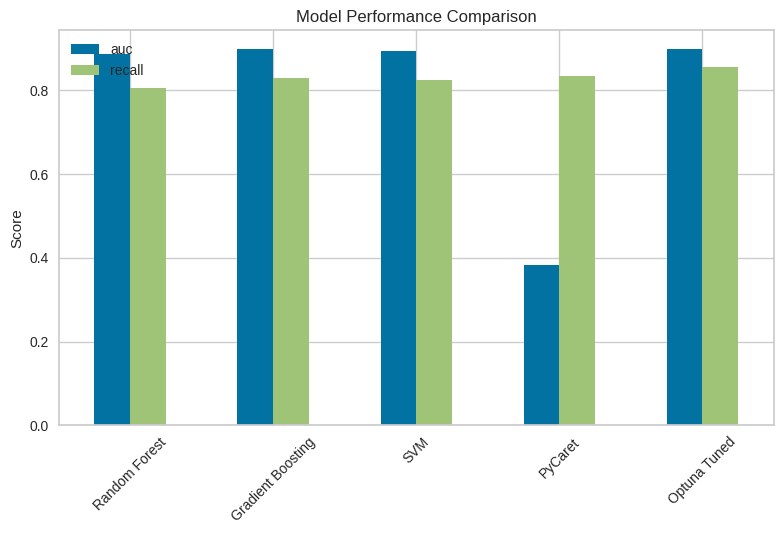

                        auc    recall  harmonic_mean
Optuna Tuned       0.898468  0.854733       0.876055
Gradient Boosting  0.898422  0.828491       0.862040
SVM                0.893348  0.824742       0.857675
Random Forest      0.886189  0.805998       0.844194
PyCaret            0.384209  0.833177       0.525904


In [35]:
# 셀 8: 최종 모델 평가 및 결과 시각화
best_params = study.best_params
final_model = RandomForestClassifier(**best_params, random_state=42)
final_model.fit(X_train_selected, y_train)

final_y_prob = final_model.predict_proba(X_test_selected)[:, 1]
final_auc = roc_auc_score(y_test, final_y_prob)
final_y_pred = final_model.predict(X_test_selected)
final_recall = recall_score(y_test, final_y_pred)

print(f"Final Model - AUC: {final_auc:.4f}, Recall: {final_recall:.4f}")
print(f"Best Hyperparameters: {best_params}")
print(classification_report(y_test, final_y_pred))

results['PyCaret'] = {'auc': pycaret_auc, 'recall': pycaret_recall}
results['Optuna Tuned'] = {'auc': final_auc, 'recall': final_recall}

df_results = pd.DataFrame(results).T
df_results['harmonic_mean'] = 2 / (1/df_results['auc'] + 1/df_results['recall'])

plt.figure(figsize=(12, 6))
df_results[['auc', 'recall']].plot(kind='bar')
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(df_results.sort_values('harmonic_mean', ascending=False))